# Lifetime Value

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import subprocess
import datetime
import re

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from scipy.stats import boxcox
from scipy import stats


import warnings
warnings.filterwarnings('ignore')

In [43]:
home_dir = '/home/jupyter/data_science_projects/business_data_science'

data_dir = os.path.join(home_dir, 'data/external/OnlineRetail.csv')

cluster_no = 4

In [44]:
df = pd.read_csv(data_dir, encoding="unicode_escape").drop_duplicates().dropna().reset_index(drop=True)

# Changing data types
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# time series variables
df['date'] = pd.to_datetime(df.InvoiceDate).dt.date
df['year'] = pd.to_datetime(df.InvoiceDate).dt.year
df['month'] = pd.to_datetime(df.InvoiceDate).dt.month
df['day'] = pd.to_datetime(df.InvoiceDate).dt.day
df['yearmo'] = pd.to_datetime(df.InvoiceDate).dt.strftime('%Y%m')
# new variable

df['Revenue'] = df['Quantity'] * df['UnitPrice']

# Clean the data
df = df.loc[~df['InvoiceNo'].str.contains('C')]

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392732 entries, 0 to 401603
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392732 non-null  object        
 1   StockCode    392732 non-null  object        
 2   Description  392732 non-null  object        
 3   Quantity     392732 non-null  int64         
 4   InvoiceDate  392732 non-null  datetime64[ns]
 5   UnitPrice    392732 non-null  float64       
 6   CustomerID   392732 non-null  float64       
 7   Country      392732 non-null  object        
 8   date         392732 non-null  object        
 9   year         392732 non-null  int64         
 10  month        392732 non-null  int64         
 11  day          392732 non-null  int64         
 12  yearmo       392732 non-null  object        
 13  Revenue      392732 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(4), object(6)
memory usage: 44.9+ MB


In [46]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,year,month,day,yearmo,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010,12,1,201012,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010,12,1,201012,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010,12,1,201012,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010,12,1,201012,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010,12,1,201012,20.34


#### Calculations
We're going to calculate the Lifetime Value using something akin to this:
$$
CLV = (Average Order Value*Purchase Frequency)/(Churn Rate) X Profit Margin
$$


In [ ]:
#### Convenience Functions

In [50]:
def transform_and_scale(data, reverse_field=None):
    """
    Purpose: Transform data using Boxcox and StandardScaler
    Input: data - a dataframe column
    Output: transformed data
    """
    print('Transforming using Boxcox and StandardScaler...')
    if reverse_field:
        print(f'With Reverse Field(s): {reverse_field}')
    #print(data.head())
    if not isinstance(data,pd.core.frame.DataFrame):
        data = data.to_frame()
    for c in data.columns:
        print(f"Transforming {c}...")
        v,l = boxcox(abs(data[c]+.0000000001))
        data[c] = v
        
        print(f"Scaling {c}...")
        scaler = MinMaxScaler()
        data[c] = scaler.fit_transform(np.array(data[c].to_frame()))
        
        if reverse_field:
            print(f"Reversing {c}...")
            data[c] = 1 - data[c] 
           
    #print(data.head())
    return data

def assign_cluster(data, n_clusters, reverse_field=None):
    """
    Purpose: Assign cluster
    Input: 
        data - a dataframe column
        n_clusters - number of clusters
        reverse_field - list or string for columns to reverse
    Output:
        an array with a new column called Cluster
        """
    
    #Scales and Transforms data
    data = transform_and_scale(data, reverse_field=reverse_field)
    
    print('Assigning cluster...')
    kmeans = KMeans(n_clusters=n_clusters, max_iter=1000, n_init='auto')
    
    # Predicts Cluster
    data['clusters'] = kmeans.fit_predict(data) + 1
    
    return data['clusters']

def rerank_clusters(data, data_col, cluster_col, reverse_field=None):
    """
    Purpose: Rerank clusters
    Input:
        data - a dataframe 
        data_col - a column name for the column representing the data
        cluster_col - a column name for the column representing a cluster to rerank
            
    Output:
        data - a dataframe 
    
    """
    
    if isinstance(data_col, list):
        data['new_data_col'] = np.sum(data[data_col], axis=1)
        data_col = 'new_data_col'
          
    tdf = data.groupby(cluster_col, as_index=False)\
    .agg(NewCluster = (data_col, 'mean'))\
    .rank(method="dense")
    
    if reverse_field:
        print(f'Reversing {reverse_field} clusters...')
        tdf.sort_values('NewCluster', ascending=False, inplace=True)
        l = tdf['NewCluster'].to_list()
        l.reverse()
        tdf['NewCluster'] = l
    
    data = data.merge(tdf
      , on=cluster_col, how='inner')\
      .rename(columns={cluster_col:"drop_column"})\
      .rename(columns={'NewCluster':cluster_col})\
      .drop('drop_column', axis=1)\

    if isinstance(data_col, list):
        data.drop('new_data_col', axis=1, inplace=True)
        
    return data

def generate_cluster_df(df, n_clusters,col=None, reverse_field=None):
    """
    Purpose: Generate cluster data
    Input: 
        df - a dataframe column
        n_clusters - number of clusters
        col - a column name
        reverse_field - list or string for columns to reverse
    Output: 
        a dataframe with a new column called Cluster
        """
    #print(df.head())
    #print(reverse_field)
    if isinstance(col, str):
        output_col_name = f'{col}Cluster'
        
    elif isinstance(col, list):
        output_col_name = 'FinalCluster'
    
    df[output_col_name] = assign_cluster(df[col], n_clusters,reverse_field=reverse_field)
    
    df = rerank_clusters(df, cluster_col = output_col_name, data_col=col, reverse_field=reverse_field)
    #print(df.head())
    return df

def analyze_clusters(df,col, n_clusters:int, reverse_field=None):
    """
    Purpose: Analyze clusters
    Input: 
        df - a dataframe column
        col - a column name
        n_clusters - number of clusters
        reverse_field - column name or list of column names. If reverse_field is not None, reverses the fieldeven without "reverse" being true.
        
    Output: 
        a dataframe with a new column called Cluster
        """
    if reverse_field and not isinstance(reverse_field, list):
        reverse_field = [reverse_field]

    df =  generate_cluster_df(df=df, n_clusters=n_clusters, col=col, reverse_field=reverse_field)
    
    return df


In [62]:
# New DF
new_df = df.loc[~df.InvoiceNo.str.contains('C')].copy()

In [63]:
#### Recency

In [64]:
new_df['Recency'] =  (pd.to_datetime(new_df.InvoiceDate).max() - new_df.InvoiceDate).dt.days

r_df = new_df.groupby(['CustomerID']).agg({'InvoiceDate': 'max'}).reset_index()\
.merge(new_df[['CustomerID', 'InvoiceDate','Recency']], on=['CustomerID','InvoiceDate'], how='inner')\
.drop_duplicates().reset_index(drop=True).drop(['InvoiceDate'], axis=1)


In [65]:
#### Frequency

In [66]:
f_df = new_df[['InvoiceDate','CustomerID']].drop_duplicates().sort_values(by=['CustomerID','InvoiceDate'], ascending=True).reset_index(drop=True)

#Creating difference between invoice dates per person
f_df['Offset'] = f_df.groupby(['CustomerID'])['InvoiceDate'].diff().dt.seconds

# Creating Count per user
f_df = f_df.merge(\
    f_df.groupby(['CustomerID']).agg(Count = ('InvoiceDate', 'count')).reset_index()\
           ,on=['CustomerID'], how='inner')

# Finding folks who only had one interaction and giving them an Offset that is differenced from the latest day in the dataset
f_df.loc[f_df.Count == 1, 'Offset'] = (f_df.InvoiceDate.max() - f_df.InvoiceDate).dt.seconds

# Dropping the first occurance of a invoicedate.  Not needed to make agg.
f_df = f_df.loc[~(f_df.Offset.isna())]

f_df = f_df.groupby(['CustomerID']).agg(Frequency = ('Offset','median')).reset_index()

#f_df['FrequencyHertz'] = 1/f_df.Frequency

In [67]:
#### Monetary

In [68]:
# We use DF instead of new_df here because we want to penalize users for their returns.
m_df = df[['CustomerID','Revenue']].groupby('CustomerID').agg(Revenue = ('Revenue', 'sum')).reset_index()

In [69]:
r_df = analyze_clusters(r_df, n_clusters=cluster_no,col ='Recency',reverse_field='Recency')
r_df.groupby('RecencyCluster')['Recency'].describe()

Transforming using Boxcox and StandardScaler...
With Reverse Field(s): ['Recency']
Transforming Recency...
Scaling Recency...
Reversing Recency...
Assigning cluster...
Reversing ['Recency'] clusters...


,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
1.0,1282.0,227.336973,75.501759,111.0,162.25,218.0,283.0,373.0
2.0,1750.0,53.529143,23.812134,22.0,32.00,50.0,71.0,110.0
3.0,1214.0,9.864909,6.233691,1.0,4.00,9.0,15.0,21.0
4.0,93.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0


In [70]:
f_df = analyze_clusters(f_df, 'Frequency', cluster_no, reverse_field='Frequency')
f_df.groupby('FrequencyCluster')['Frequency'].describe()

Transforming using Boxcox and StandardScaler...
With Reverse Field(s): ['Frequency']
Transforming Frequency...
Scaling Frequency...
Reversing Frequency...
Assigning cluster...
Reversing ['Frequency'] clusters...


,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
1.0,1766.0,77443.522084,5984.954758,58740.0,73515.0,78420.0,82320.0,86340.0
2.0,661.0,41375.037821,6572.928193,22920.0,39600.0,42420.0,45090.0,57300.0
3.0,1223.0,11334.260016,4314.318689,5220.0,7800.0,10560.0,13980.0,22860.0
4.0,689.0,2335.297533,1564.754496,0.0,900.0,2340.0,3690.0,5160.0


In [71]:
m_df = analyze_clusters(m_df, 'Revenue', cluster_no)
m_df.groupby('RevenueCluster')['Revenue'].describe()

Transforming using Boxcox and StandardScaler...
Transforming Revenue...
Scaling Revenue...
Assigning cluster...


,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
1.0,1176.0,188.196675,78.188939,0.00,126.135,184.225,252.070,321.43
2.0,1676.0,639.896720,231.895000,321.79,430.495,605.610,811.285,1139.73
3.0,1186.0,2253.440591,908.522449,1140.21,1497.735,2001.720,2803.260,4654.08
4.0,301.0,16348.312824,30554.802562,4668.30,5655.990,7354.620,12416.110,280206.02


In [72]:
final_df = m_df.merge(r_df, on='CustomerID', how='inner').merge(f_df, on='CustomerID', how='inner')

final_df = final_df[['CustomerID','Recency','Frequency','Revenue','RecencyCluster','FrequencyCluster','RevenueCluster']]

In [73]:
#rfm = analyze_clusters(final_df, ['Revenue', 'Frequency', 'Recency'], cluster_no, reverse_field=['Recency', 'Frequency']).drop('new_data_col', axis=1)


Transforming using Boxcox and StandardScaler...
With Reverse Field(s): ['Recency', 'Frequency']
Transforming Revenue...
Scaling Revenue...
Reversing Revenue...
Transforming Frequency...
Scaling Frequency...
Reversing Frequency...
Transforming Recency...
Scaling Recency...
Reversing Recency...
Assigning cluster...
Reversing ['Recency', 'Frequency'] clusters...


In [77]:
new_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,year,month,day,yearmo,Revenue,Recency
37511,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,2011-01-18,2011,1,18,201101,77183.60,325
10408,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,12,2010-12-07 14:57:00,2.10,12347.0,Iceland,2010-12-07,2010,12,7,201012,25.20,366
10409,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2010-12-07 14:57:00,4.25,12347.0,Iceland,2010-12-07,2010,12,7,201012,17.00,366
10410,537626,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,12,2010-12-07 14:57:00,3.25,12347.0,Iceland,2010-12-07,2010,12,7,201012,39.00,366
10411,537626,22492,MINI PAINT SET VINTAGE,36,2010-12-07 14:57:00,0.65,12347.0,Iceland,2010-12-07,2010,12,7,201012,23.40,366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288299,570715,22419,LIPSTICK PEN RED,12,2011-10-12 10:23:00,0.42,18287.0,United Kingdom,2011-10-12,2011,10,12,201110,5.04,58
288300,570715,22866,HAND WARMER SCOTTY DOG DESIGN,12,2011-10-12 10:23:00,2.10,18287.0,United Kingdom,2011-10-12,2011,10,12,201110,25.20,58
314103,573167,23264,SET OF 3 WOODEN SLEIGH DECORATIONS,36,2011-10-28 09:29:00,1.25,18287.0,United Kingdom,2011-10-28,2011,10,28,201110,45.00,42
314104,573167,21824,PAINTED METAL STAR WITH HOLLY BELLS,48,2011-10-28 09:29:00,0.39,18287.0,United Kingdom,2011-10-28,2011,10,28,201110,18.72,42


#### Develop Churn Rules
We are going to explore "Frequency" and "Recency" to see if there are patterns that can lead us to determin a statistically sound "cut off" for churn

##### Frequency

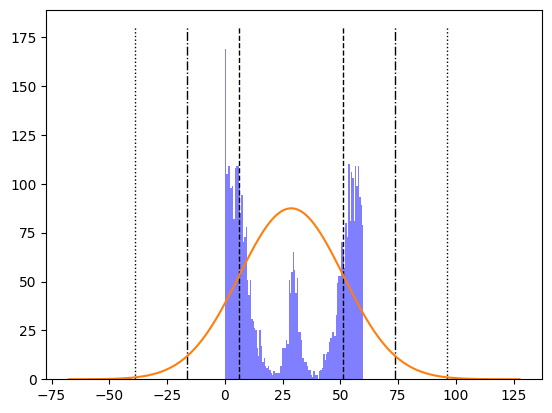

<Axes: xlabel='Frequency'>

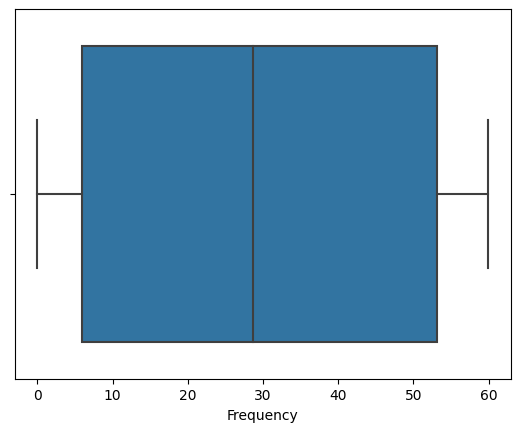

In [257]:
x = final_df.Frequency.transform(lambda x: x/(60*24))

num_bins = 100

plt.hist(x, bins=num_bins, facecolor='blue', alpha=0.5)

mean = np.mean(x)
sd = np.std(x)

#x_axis = np.arange(x.min() - sd*3, x.max() + sd*3, len(x_axis))
x_axis = np.linspace(x.min() - sd*3, x.max() + sd*3, num =1000)

param = np.log(np.floor(x.max()))-2
x_norm = stats.norm.pdf(x_axis, loc=mean, scale=sd)*(x.max()**param)

plt.plot([mean-sd,mean-sd],[0,180], color='k', lw=1, ls='dashed')
plt.plot([mean+sd,mean+sd],[0,180], color='k', lw=1, ls='dashed')

plt.plot([mean-sd*2,mean-sd*2],[0,180], color='k', lw=1, ls='dashdot')
plt.plot([mean+sd*2,mean+sd*2],[0,180], color='k', lw=1, ls='dashdot')

plt.plot([mean-sd*3,mean-sd*3],[0,180], color='k', lw=1, ls='dotted')
plt.plot([mean+sd*3,mean+sd*3],[0,180], color='k', lw=1, ls='dotted')

plt.plot(x_axis, x_norm)
plt.show()

sns.boxplot(x='Frequency',data=pd.DataFrame(x))

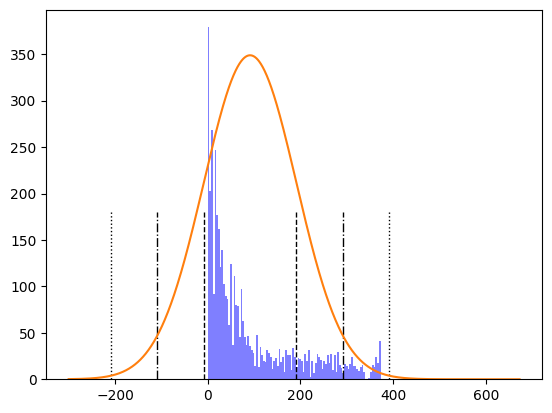

<Axes: xlabel='Recency'>

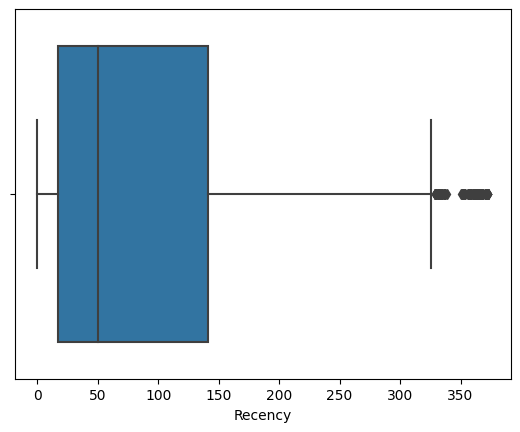

In [258]:
x = final_df.Recency

num_bins = 100

plt.hist(x, bins=num_bins, facecolor='blue', alpha=0.5)

mean = np.mean(x)
sd = np.std(x)

#x_axis = np.arange(x.min() - sd*3, x.max() + sd*3, len(x_axis))
x_axis = np.linspace(x.min() - sd*3, x.max() + sd*3, num =1000)

param = np.log(np.floor(x.max()))-4
x_norm = stats.norm.pdf(x_axis, loc=mean, scale=sd)*(x.max()**param)

plt.plot([mean-sd,mean-sd],[0,180], color='k', lw=1, ls='dashed')
plt.plot([mean+sd,mean+sd],[0,180], color='k', lw=1, ls='dashed')

plt.plot([mean-sd*2,mean-sd*2],[0,180], color='k', lw=1, ls='dashdot')
plt.plot([mean+sd*2,mean+sd*2],[0,180], color='k', lw=1, ls='dashdot')

plt.plot([mean-sd*3,mean-sd*3],[0,180], color='k', lw=1, ls='dotted')
plt.plot([mean+sd*3,mean+sd*3],[0,180], color='k', lw=1, ls='dotted')

plt.plot(x_axis, x_norm)
plt.show()

sns.boxplot(x='Recency',data=pd.DataFrame(x))

Takeaways:

Signs point to Recency being a better way to create a "cut off" for Churn.
Furthermore, it seems that the 3rd Standard Deviation and the 75th Percentile + 1.5xIQR boundaries are fairly close.
Lets see how much many "churned" outliers we can identify using those rules.

In [274]:
def get_iqr(x):
    return np.percentile(x, 75) - np.percentile(x, 25)

def get_upper_quartile_plus_iqr(x):
    return np.percentile(x, 75) + get_iqr(x)

upper_iqr_boundary = get_upper_quartile_plus_iqr(final_df.Recency)
upper_sd_3_boundary = np.std(final_df.Recency)*3

print(f"Upper IQR: {upper_iqr_boundary}\nUpper SD: {upper_sd_3_boundary}")

Upper IQR: 265.0
Upper SD: 299.99466678845175


In [284]:
# Using IQR, which is outlier/non-normal distribution robust
final_df.loc[final_df.Recency > upper_iqr_boundary][['Recency','Frequency','Revenue','RecencyCluster',
       'FrequencyCluster', 'RevenueCluster']].describe()

,Recency,Frequency,Revenue,RecencyCluster,FrequencyCluster,RevenueCluster
count,414.000000,414.000000,414.000000,414.0,414.000000,414.000000
mean,317.958937,39851.376812,590.005990,1.0,2.311594,1.449275
std,35.011873,36040.235187,3822.433622,0.0,1.255308,0.623267
min,266.000000,0.000000,3.750000,1.0,1.000000,1.000000
25%,287.000000,5880.000000,153.225000,1.0,1.000000,1.000000
50%,312.000000,14940.000000,264.900000,1.0,3.000000,1.000000
75%,357.000000,79290.000000,417.252500,1.0,3.000000,2.000000
max,373.000000,86340.000000,77183.600000,1.0,4.000000,4.000000


In [283]:
#Using Standard Deviation
final_df.loc[final_df.Recency > upper_sd_3_boundary][['Recency','Frequency','Revenue','RecencyCluster',
       'FrequencyCluster', 'RevenueCluster']].describe()

,Recency,Frequency,Revenue,RecencyCluster,FrequencyCluster,RevenueCluster
count,268.000000,268.00000,268.000000,268.0,268.000000,268.000000
mean,338.507463,40023.69403,667.817425,1.0,2.302239,1.436567
std,25.391245,36146.90331,4719.613409,0.0,1.254981,0.623875
min,300.000000,60.00000,15.000000,1.0,1.000000,1.000000
25%,314.750000,5835.00000,154.852500,1.0,1.000000,1.000000
50%,333.000000,14790.00000,251.230000,1.0,3.000000,1.000000
75%,365.000000,79560.00000,404.957500,1.0,3.000000,2.000000
max,373.000000,86340.00000,77183.600000,1.0,4.000000,4.000000


Takeaway:  They are close.  Neither captures a sufficient number of folks who fall in other clusters to really shift the dynamics of lifetime value based on RFM clusters.

Given the fact that Recency is not normally distributed and for the sake of being robust to outliers, we are going to use the IQR method.